In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sn
import pandas as pd
import torchnet.meter.confusionmeter as cm
import random

c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import PIL
from PIL import Image
import skimage
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

In [3]:
def augmenttest():
        path_img = 'marvel/train/hulk/pic_001.jpg'
        img = skimage.io.imread(path_img)
        img_pil = Image.fromarray(np.asarray(img))
        #augm = transforms.RandomRotation(degrees=(-20,20))
        augm = transforms.Compose([transforms.RandomApply(transforms=nn.ModuleList([transforms.RandomRotation(degrees=(-20,20))]), p=0.3),
                transforms.RandomApply(transforms=nn.ModuleList([transforms.RandomResizedCrop(224,(0.5,1))]), p=0.3),
                transforms.RandomApply(transforms=nn.ModuleList([transforms.RandomHorizontalFlip()]), p=0.3),
                transforms.CenterCrop(224),])
        img_auged = augm(img_pil)

        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), sharex = True, sharey = True)

        ax1.axis('off')
        ax1.imshow(img_pil)
        ax1.set_title('Input')

        ax2.axis('off')
        ax2.imshow(np.array(img_auged), cmap=plt.cm.gray)
        ax2.set_title('Histogram of Oriented Gradients')
        plt.show()

        print(img.shape)
        #print(img_auged.size)

In [4]:

# Data augmentation and normalization for training
# Just normalization for validation & test

data_transforms = {
    'train': transforms.Compose([
        #transforms.RandAugment(),
        # apply limited data augmentation methods randomly
        transforms.RandomApply(transforms=nn.ModuleList([transforms.RandomRotation(degrees=(-10,10))]), p=0.2),
        transforms.RandomApply(transforms=nn.ModuleList([transforms.RandomResizedCrop(224,(0.5,1))]), p=0.2),
        transforms.RandomApply(transforms=nn.ModuleList([transforms.RandomHorizontalFlip()]), p=0.2),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# define basic variables

data_dir = 'marvel'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

kf = KFold(n_splits=3, shuffle=True, random_state=114514)

batch_size = 16

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
#Train the model

def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes):
    epoch_counter_train = []
    epoch_counter_val = []
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {} in {}'.format(epoch +1, num_epochs))
        print('---' * 5)

        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set to training mode
            else:
                model.eval()   # Set to evaluating mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double().cpu() / dataset_sizes[phase]

            #For graph generation
            if phase == "train":
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                epoch_counter_train.append(epoch)
            if phase == "valid":
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                epoch_counter_val.append(epoch)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the best model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    # final validation for each class
    phase = 'valid'
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    
    y_true = []
    y_pre = []
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            y_true.extend(labels.to('cpu'))
            y_pre.extend(preds.to('cpu'))
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    print(classification_report(y_true,y_pre))

    #for printing        
    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double().cpu() / dataset_sizes[phase]
    
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))
    print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_loss, epoch_acc


In [6]:
best_model_wts = None
init_model_wts = None
max_acc = -999

#Using a model pre-trained on ImageNet and replacing it's final linear layer
#For resnet18 or resnet50
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    #nn.Flatten(),
    nn.Linear(num_ftrs, 64),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 8),
    )
model_ft = model_ft.to(device)
init_model_wts = copy.deepcopy(model_ft.state_dict())

# Using label smoothing for false-labeled input data
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Using Adam as the parameter optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr = 0.001, betas=(0.9, 0.999))

# Decay Learning rate by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

# Using k-fold cross validation
for i, (train_index, val_index) in enumerate(kf.split(image_datasets['train'])):

    train = torch.utils.data.Subset(image_datasets['train'], train_index)
    val = torch.utils.data.Subset(image_datasets['train'], val_index)

    trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
    valloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True, num_workers=4)

    # load images in 'valid' folder as test data
    testloader = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size,
                                                shuffle=True, num_workers=4)

    dataloaders = {'train': trainloader, 'valid': valloader, 'test': testloader}
                                                
    dataset_sizes = {'train': len(train_index),
                    'valid': len(val_index),
                    'test': len(dataloaders['test'].dataset)}
                    
    #lists for graph generation
    epoch_counter_train = []
    epoch_counter_val = []
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    model_ft.load_state_dict(init_model_wts)
    optimizer_ft = optim.Adam(model_ft.parameters(), lr = 0.001, betas=(0.9, 0.999))

    # Decay Learning rate by a factor of 0.1 every 10 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
    
    model_ft, loss, acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50, dataloaders = dataloaders, dataset_sizes = dataset_sizes)
    if (acc > max_acc):
        best_model_wts = copy.deepcopy(model_ft.state_dict())
        max_acc = acc
    


c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 in 50
---------------
train Loss: 1.9234 Acc: 0.2962
valid Loss: 1.9779 Acc: 0.2622

Epoch 2 in 50
---------------
train Loss: 1.8062 Acc: 0.3833
valid Loss: 1.9902 Acc: 0.3202

Epoch 3 in 50
---------------
train Loss: 1.6918 Acc: 0.4448
valid Loss: 1.9122 Acc: 0.3956

Epoch 4 in 50
---------------
train Loss: 1.6089 Acc: 0.4936
valid Loss: 1.7652 Acc: 0.4118

Epoch 5 in 50
---------------
train Loss: 1.5249 Acc: 0.5360
valid Loss: 1.7024 Acc: 0.4304

Epoch 6 in 50
---------------
train Loss: 1.4462 Acc: 0.5918
valid Loss: 1.5767 Acc: 0.5116

Epoch 7 in 50
---------------
train Loss: 1.4115 Acc: 0.5947
valid Loss: 1.5620 Acc: 0.5139

Epoch 8 in 50
---------------
train Loss: 1.3294 Acc: 0.6388
valid Loss: 1.7057 Acc: 0.5023

Epoch 9 in 50
---------------
train Loss: 1.3061 Acc: 0.6423
valid Loss: 1.9198 Acc: 0.4316

Epoch 10 in 50
---------------
train Loss: 1.2562 Acc: 0.6661
valid Loss: 1.5742 Acc: 0.5371

Epoch 11 in 50
---------------
train Loss: 1.1001 Acc: 0.7398
valid L

In [7]:

def plot_result():#Plot the train & validation losses
    plt.figure(1)
    plt.title("Training Vs Validation Losses")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epoch_counter_train,train_loss,color = 'r', label="Training Loss")
    plt.plot(epoch_counter_val,val_loss,color = 'g', label="Validation Loss")
    plt.legend()
    plt.savefig('loss_smooth8.jpg')
    plt.show()

    #Plot the accuracies in train & validation
    plt.figure(2)
    plt.title("Training Vs Validation Accuracies")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(epoch_counter_train,train_acc,color = 'r', label="Training Accuracy")
    plt.plot(epoch_counter_val,val_acc,color = 'g', label="Validation Accuracy")
    plt.legend()
    plt.savefig('acc_smooth8.jpg')
    plt.show()

c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy of the network on the test images: 58 %
Accuracy of black widow : 47 %
Accuracy of captain america : 49 %
Accuracy of doctor strange : 50 %
Accuracy of  hulk : 58 %
Accuracy of ironman : 48 %
Accuracy of  loki : 55 %
Accuracy of spider-man : 75 %
Accuracy of thanos : 63 %
[[24 11  2  3  6  2  2  5]
 [ 6 24  2  3 10  4  6  2]
 [ 4  1 30  3  3  4  6 10]
 [ 4  2  4 35  3  3  0  5]
 [ 2  9  2  3 28  1  6  5]
 [ 3  2  2  5  2 33  0  7]
 [ 2  5  1  1  3  0 44  1]
 [ 0  2  2  4  4  3  1 39]]


<AxesSubplot:>

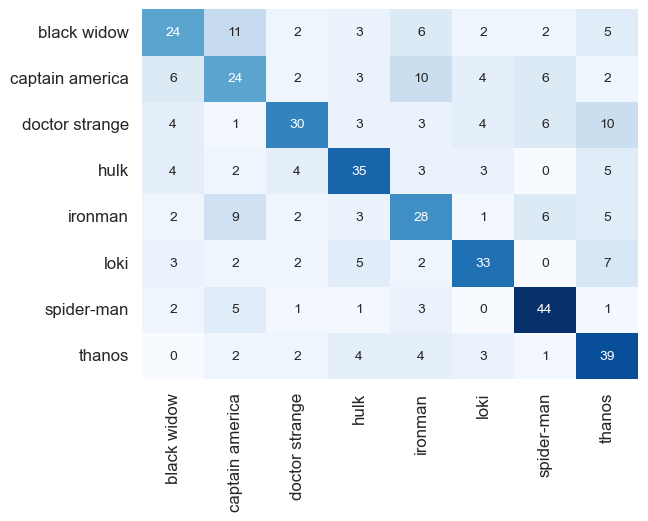

In [8]:

#Test the accuracy with test data

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    #nn.Flatten(),
    nn.Linear(num_ftrs, 64),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 8),
    )
model_ft = model_ft.to(device)
model_ft.load_state_dict(best_model_wts)

correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

#Class wise testing accuracy
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))


#Get the confusion matrix for testing data
confusion_matrix = cm.ConfusionMeter(8)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    print(confusion_matrix.conf)

#Confusion matrix as a heatmap
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sn.set(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues") 